# Term Deposit Subscription Prediction (Bank Marketing)

In [ ]:
# ============================================================
# Task 1 — Term Deposit Subscription Prediction (Bank Marketing)
# Steps: Load → Encode → Train (LR + RF) → Evaluate → SHAP (5 preds)
# Dataset: adilshamim8/binary-classification-with-a-bank-dataset
# ============================================================

# ================================
# 0) Install & Imports
# ================================
!pip install -q kagglehub shap scikit-learn pandas matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

import shap

# For nicer plots
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [ ]:
# ================================
# 1) Load Dataset
# ================================

import os
import pandas as pd
import kagglehub

# Download dataset from Kaggle
path = kagglehub.dataset_download("adilshamim8/binary-classification-with-a-bank-dataset")

# Define paths for train & test
train_path = os.path.join(path, "train.csv")
test_path = os.path.join(path, "test.csv")

# Load CSV files
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("✅ Train shape:", df_train.shape)
print("✅ Test shape:", df_test.shape)

# Preview training data
df_train.head()


✅ Train shape: (750000, 18)
✅ Test shape: (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [ ]:
# ================================
# 2) Preprocessing (fixed for numeric y)
# ================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define target column
target = "y"   # already 0/1 in dataset

# Split train.csv into features and labels
X = df_train.drop(columns=[target, "id"])   # drop id (not useful)
y = df_train[target]                        # already 0/1

# Create train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# For preprocessing: identify categorical & numerical features
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)

# Preprocessing: OneHotEncode for categorical, StandardScaler for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features)
    ]
)


Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# ================================
# Step 3: Preprocessing Pipeline
# ================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Identify categorical & numerical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100, random_state=42
    ))
])


In [5]:
# ================================
# Step 4: Train & Evaluate Model
# ================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train
rf_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf_pipeline.predict(X_val)

# Evaluation on the validation set
print("🔹 Model Performance Metrics (Validation Set):")
print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred, zero_division=0))
print("Recall   :", recall_score(y_val, y_pred, zero_division=0))
print("F1 Score :", f1_score(y_val, y_pred, zero_division=0))
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_pred, zero_division=0))

🔹 Model Performance Metrics (Validation Set):
Accuracy : 0.93052
Precision: 0.7475490196078431
Recall   : 0.6404022543927506
F1 Score : 0.6898398904827093

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    131902
           1       0.75      0.64      0.69     18098

    accuracy                           0.93    150000
   macro avg       0.85      0.81      0.83    150000
weighted avg       0.93      0.93      0.93    150000




🔹 Running SHAP for feature explainability...
SHAP values shape: (10, 51, 2)
Data sample shape: (10, 51)


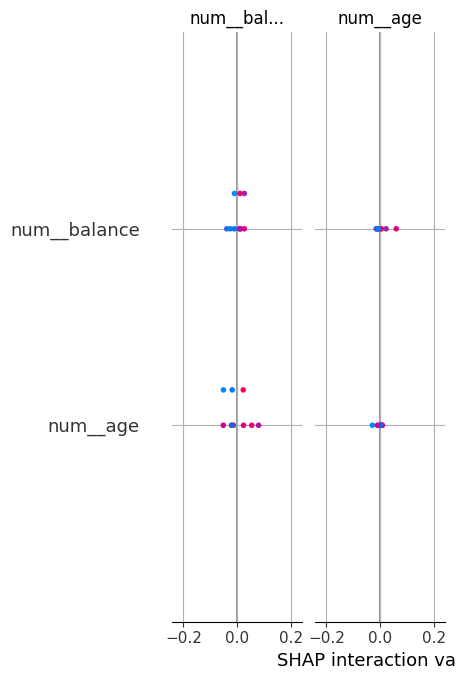

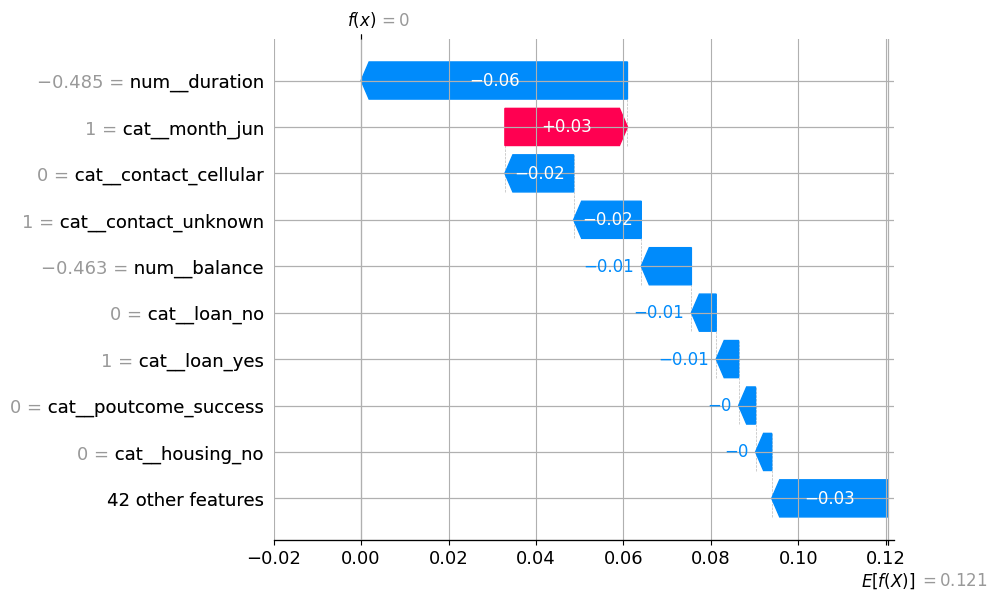

In [7]:
# ================================
# Step 5: SHAP Explainability (FAST for Tree Models) - FIXED
# ================================
import shap
import numpy as np

print("\n🔹 Running SHAP for feature explainability...")

# Extract trained RandomForest model
rf = rf_pipeline.named_steps["classifier"]

# Transform validation set
X_val_trans = rf_pipeline.named_steps["preprocessor"].transform(X_val)
feature_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Convert sparse to array if needed
if not isinstance(X_val_trans, np.ndarray):
    X_val_trans = X_val_trans.toarray()

# Use smaller sample for speed
X_sample = shap.utils.sample(X_val_trans, 10, random_state=42) # Reduced sample size to 10

# 🚀 Use TreeExplainer for RandomForest (fast + compatible with scikit-learn trees)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# ✅ Ensure correct alignment
if isinstance(shap_values, list):
    # For classifiers → pick class 1 ("Leave")
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print(f"SHAP values shape: {shap_values_class1.shape}")
print(f"Data sample shape: {X_sample.shape}")

# Global feature importance (class 1 = "Leave")
shap.summary_plot(shap_values_class1, X_sample, feature_names=feature_names, plot_type="bar")

# ✅ Explain first 1 sample (class 1 = "Leave") - Reduced to 1 waterfall plot
for i in range(1):
    # Create explanation object for ONE row + ONE class
    exp = shap.Explanation(
        values=shap_values_class1[i, : , 1],                 # SHAP values for class 1 and instance i
        base_values=explainer.expected_value[1],      # Base value for class 1
        data=X_sample[i],                             # Sample features
        feature_names=feature_names
    )
    shap.plots.waterfall(exp, max_display=10)